In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import seaborn as sns
np.random.seed(42)

In [2]:


# Load the datasets
exercise_data = pd.read_csv('exercise.csv')
calories_data = pd.read_csv('calories.csv')

# Display the first few rows of each dataset to understand their structure
exercise_data.head(), calories_data.head()


(    User_ID  Gender  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
 0  14733363    male   68   190.0    94.0      29.0       105.0       40.8
 1  14861698  female   20   166.0    60.0      14.0        94.0       40.3
 2  11179863    male   69   179.0    79.0       5.0        88.0       38.7
 3  16180408  female   34   179.0    71.0      13.0       100.0       40.5
 4  17771927  female   27   154.0    58.0      10.0        81.0       39.8,
     User_ID  Calories
 0  14733363     231.0
 1  14861698      66.0
 2  11179863      26.0
 3  16180408      71.0
 4  17771927      35.0)

In [3]:
# Merge the datasets on 'User_ID'
merged_data = pd.merge(exercise_data, calories_data, on='User_ID')

# Drop 'User_ID' since it's not needed for model training
merged_data = merged_data.drop(columns=['User_ID'])

# Display the first few rows of the merged dataset to confirm the merge
merged_data.head()


,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [4]:
merged_data.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


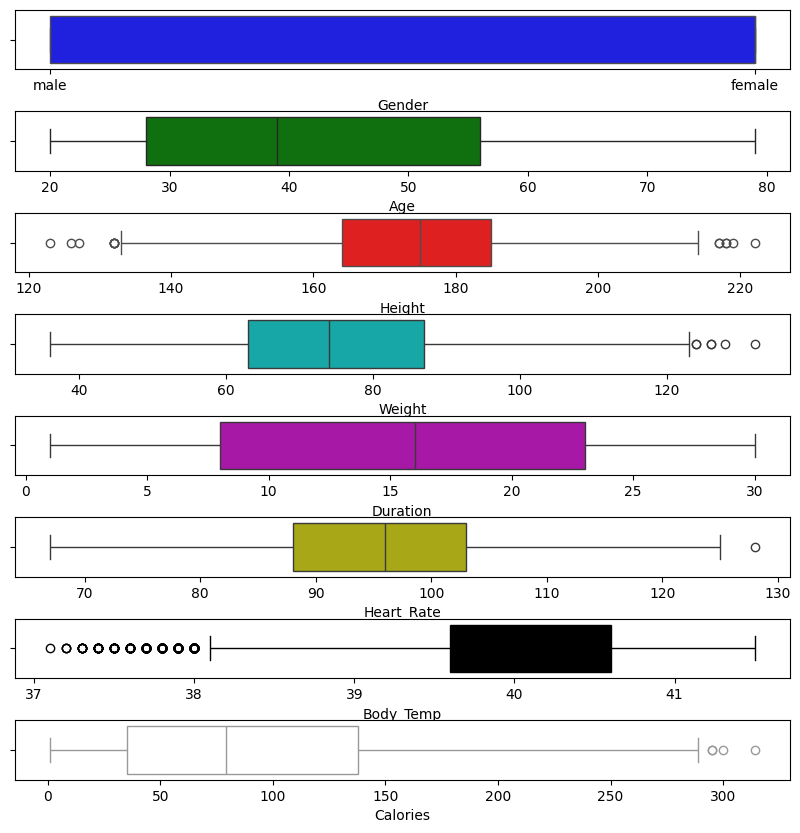

In [5]:
c = ['b' , 'g' , 'r' , 'c' , 'm' , 'y' , 'k' , 'w' , 'b']
# Create a figure and a grid of subplots, with one subplot for each column in the dataset
# The size of the figure is set to 10x10 inches
fig1 , axes = plt.subplots(len(merged_data.columns) , 1 , figsize = (10 , 10))
plt.subplots_adjust(wspace = 0.3 , hspace = 0.7)
axes = axes.flatten()             #for using axes indeces with one dimention array instead of two dimension
for i , column in zip(range(len(merged_data.columns)) , merged_data.columns):
  try:
    sns.boxplot(data = merged_data , x = column , color = c[i] , ax = axes[i])
  except:
    fig1.delaxes(axes[i])
    continue

In [6]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      15000 non-null  object 
 1   Age         15000 non-null  int64  
 2   Height      15000 non-null  float64
 3   Weight      15000 non-null  float64
 4   Duration    15000 non-null  float64
 5   Heart_Rate  15000 non-null  float64
 6   Body_Temp   15000 non-null  float64
 7   Calories    15000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 937.6+ KB


In [7]:
merged_data.isnull().sum()

Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [8]:
print("The shape of dataset before dropping duplicates : " , merged_data.shape)
merged_data.drop_duplicates( inplace = True)    
print("The shape of dataset after dropping duplicates : " , merged_data.shape)

The shape of dataset before dropping duplicates :  (15000, 8)
The shape of dataset after dropping duplicates :  (14999, 8)


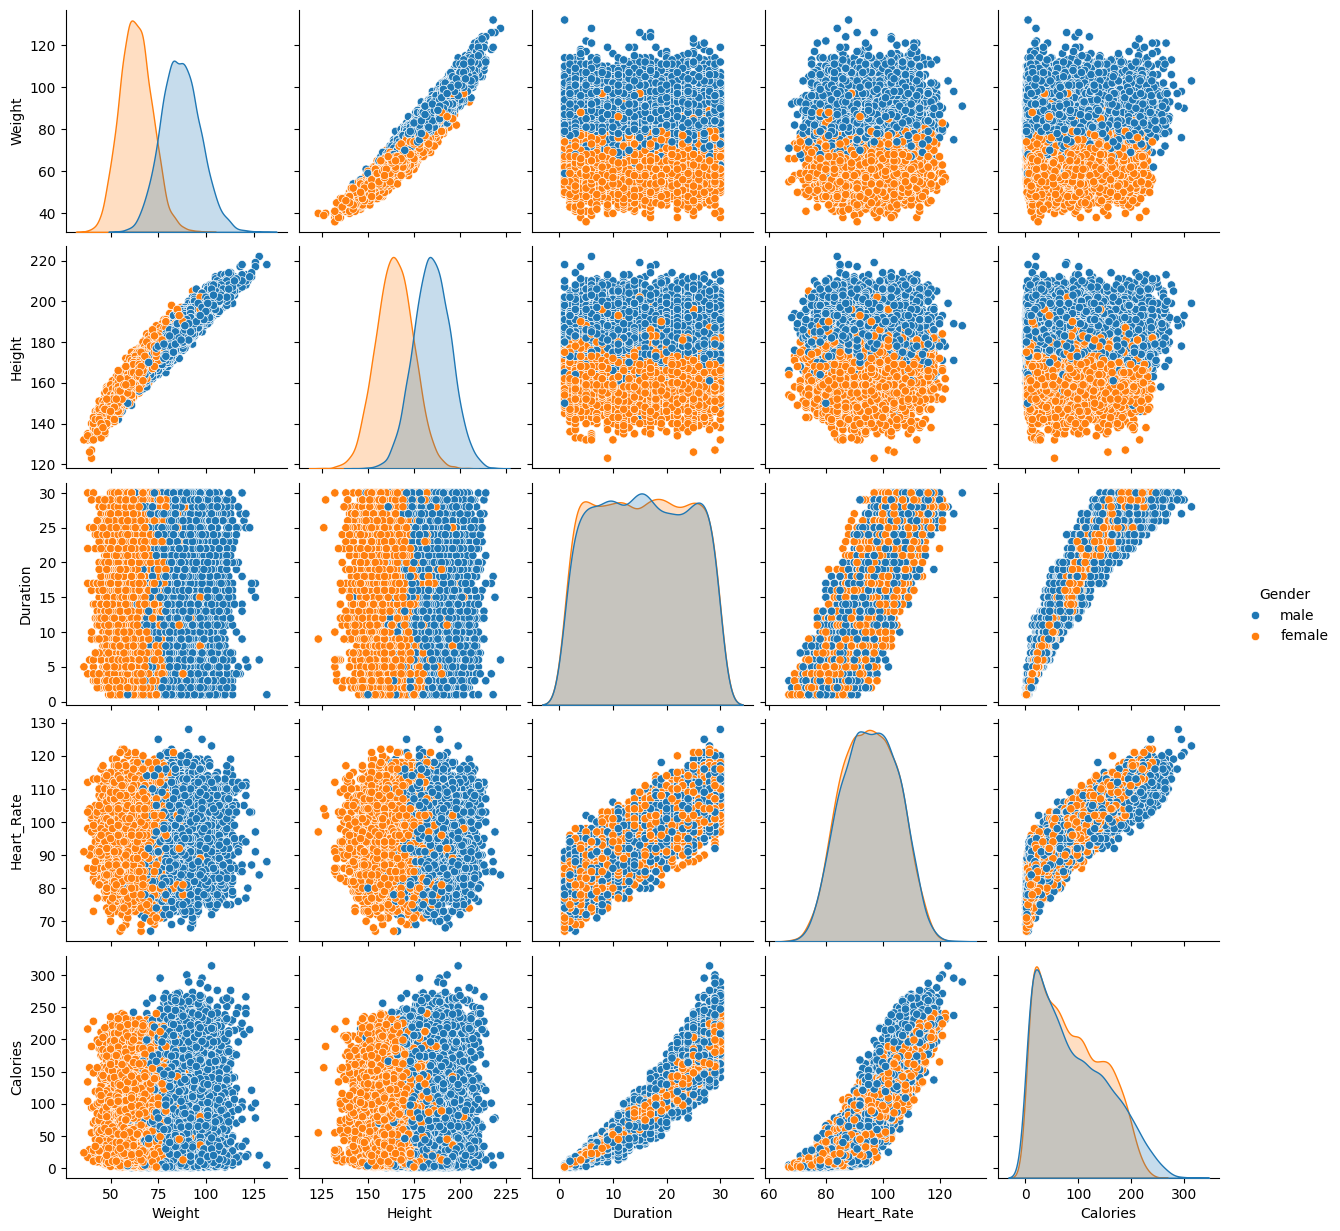

In [9]:
sns.pairplot(merged_data[["Weight" , "Height" , "Duration" , "Heart_Rate" , "Calories" , "Gender"]] , hue = "Gender")

* As we can see from graphs above, there is not a specific correlation or relationship between most of the features in the dataset.For example,there is not a specific relationship between `Duration` and `Weight` or between `Duration` and `Hight`.This is because exercisers may have different exercise duration no matter of their `Weight` and `Height`.

* In some cases, a featrue has a low relationship with another feature, like `Duration` and `Heart_Rate`.Somehow(with low confident) we can say that the more time somebody exercises the more 'Heart Rate' per minute he/she will have.

* In some cases , two featrues have a high relationship(in compare to last two cases), like `Height` and `Weight`.
.

### Building Model Model and Decide the best performing one

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode the 'Gender' feature
label_encoder = LabelEncoder()
merged_data['Gender'] = label_encoder.fit_transform(merged_data['Gender'])

# Split the dataset into features and target
X = merged_data.drop(columns=['Calories'])
y = merged_data['Calories']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the shapes of the processed training and testing sets
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape


((11999, 7), (3000, 7), (11999,), (3000,))

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np

# Define a function to calculate regression accuracy (e.g., within 10% tolerance)
def calculate_accuracy(y_true, y_pred, tolerance=0.1):
    within_tolerance = abs(y_true - y_pred) <= tolerance * y_true
    return sum(within_tolerance) / len(y_true) * 100

# Custom scoring function for cross-validation
def accuracy_scorer(y_true, y_pred):
    return calculate_accuracy(y_true, y_pred)

# Initialize models
linear_regressor = LinearRegression()
random_forest_regressor = RandomForestRegressor(random_state=42)
gradient_boosting_regressor = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42
)
svm_regressor = SVR(kernel="rbf", C=10, epsilon=0.1)
xgboost_regressor = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42
)

# Cross-validation function
def cross_validate_model(model, X, y, cv=5):
    mse_scores = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=cv)
    r2_scores = cross_val_score(model, X, y, scoring="r2", cv=cv)
    return np.mean(mse_scores), np.mean(r2_scores)

# Evaluate models using cross-validation and train-test split
models = {
    "Linear Regression": linear_regressor,
    "Random Forest": random_forest_regressor,
    "Gradient Boosting": gradient_boosting_regressor,
    "SVM": svm_regressor,
    "XGBoost": xgboost_regressor,
}

# To store metrics for each model
mse_values = []
r2_values = []
accuracies=[]

results = {}

for model_name, model in models.items():
    # Cross-validation
    mse_cv, r2_cv = cross_validate_model(model, X_train_scaled, y_train, cv=5)
    
    # Train-test split
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    accuracy = calculate_accuracy(y_test, y_pred)
    
    # Store MSE and R2 for plotting later
    mse_values.append(mse)
    r2_values.append(r2)
    accuracies.append(accuracy)
    
    # Save results
    results[model_name] = {
        "MSE (Cross-Validation)": mse_cv,
        "R2 (Cross-Validation)": r2_cv,
        "MSE (Test)": mse,
        "R2 (Test)": r2,
        "Accuracy (%) (Test)": accuracy,
    }

# Print results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()

# Print mse_values and r2_values to verify
print("MSE Values:", mse_values)
print("R² Values:", r2_values)


Linear Regression:
  MSE (Cross-Validation): 127.5470
  R2 (Cross-Validation): 0.9673
  MSE (Test): 130.5644
  R2 (Test): 0.9663
  Accuracy (%) (Test): 55.6000

Random Forest:
  MSE (Cross-Validation): 9.3082
  R2 (Cross-Validation): 0.9976
  MSE (Test): 8.5134
  R2 (Test): 0.9978
  Accuracy (%) (Test): 96.4667

Gradient Boosting:
  MSE (Cross-Validation): 2.8939
  R2 (Cross-Validation): 0.9993
  MSE (Test): 2.7947
  R2 (Test): 0.9993
  Accuracy (%) (Test): 98.1333

SVM:
  MSE (Cross-Validation): 2.9320
  R2 (Cross-Validation): 0.9993
  MSE (Test): 2.7442
  R2 (Test): 0.9993
  Accuracy (%) (Test): 97.4000

XGBoost:
  MSE (Cross-Validation): 3.0204
  R2 (Cross-Validation): 0.9992
  MSE (Test): 2.8274
  R2 (Test): 0.9993
  Accuracy (%) (Test): 98.0333

MSE Values: [130.5644224133618, 8.513416033333334, 2.794656724647676, 2.7441685068892165, 2.8273718639270573]
R² Values: [0.9662893783275958, 0.9978019085005342, 0.9992784434395874, 0.9992914790673358, 0.9992699966693048]


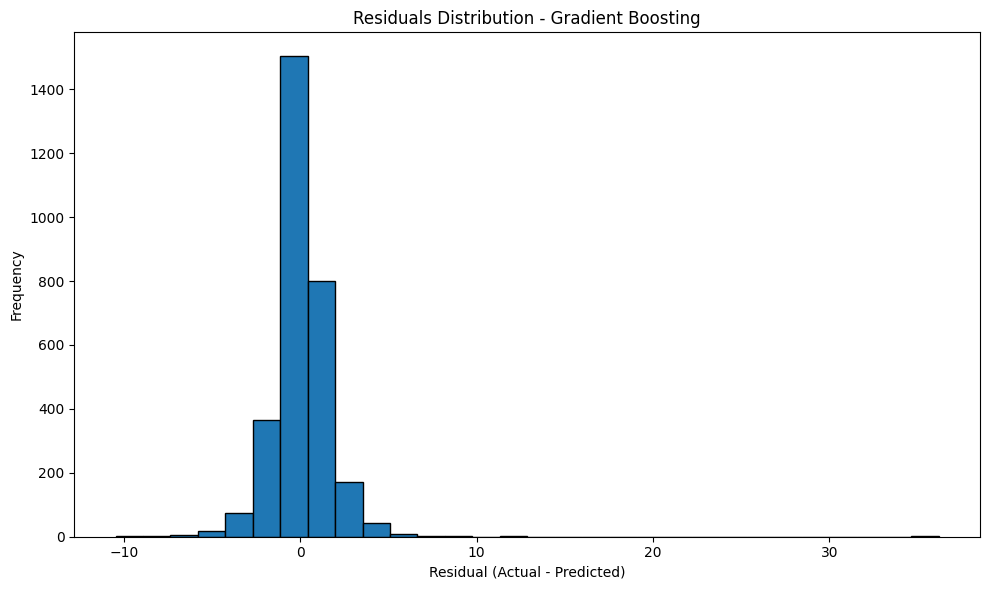

In [12]:
residuals_gb = y_test - gradient_boosting_regressor.predict(X_test_scaled)
plt.figure(figsize=(10, 6))
plt.hist(residuals_gb, bins=30, edgecolor='k')
plt.title("Residuals Distribution - Gradient Boosting")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()




Analyze data points with large residuals to see if they are anomalies or represent patterns not captured by the model.
Enhance the Model:

If the outliers are significant and frequent, consider:
Feature engineering (e.g., creating interaction terms or adding more informative features).
Hyperparameter tuning of the Gradient Boosting model.
Assess Residual Independence:

Plot residuals against predicted values or individual features to check for patterns, which could indicate areas where the model underperforms.
Compare to Other Models:


<Figure size 1600x1000 with 0 Axes>

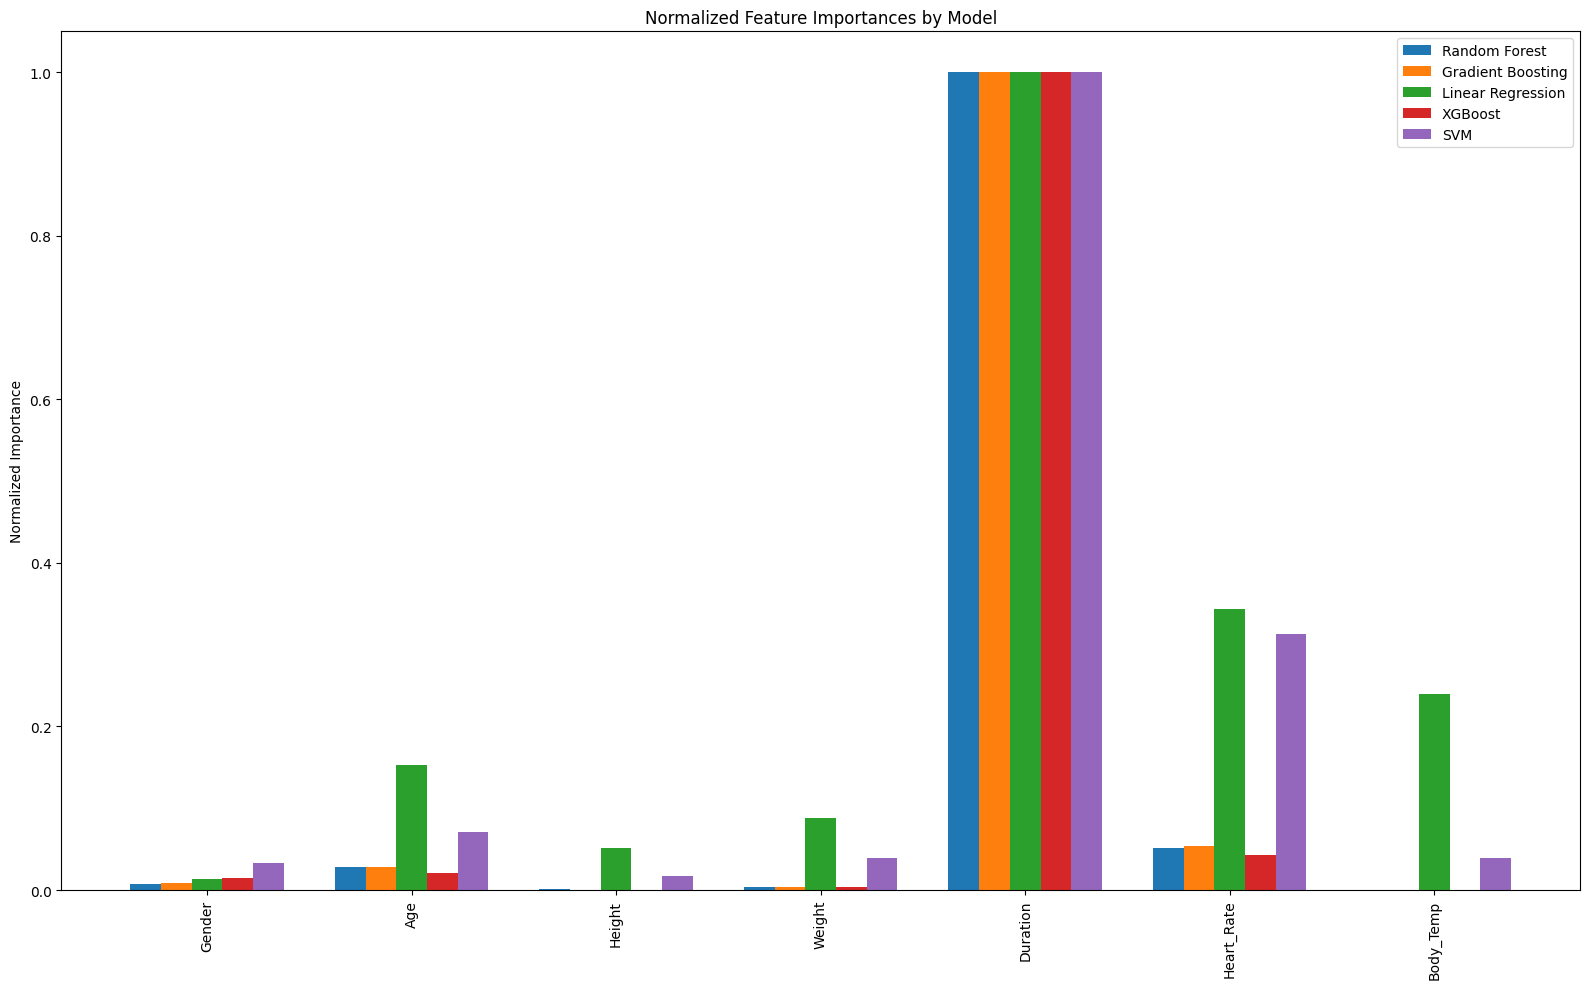

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance

# Feature importance for Random Forest and Gradient Boosting
rf_importances = random_forest_regressor.feature_importances_
gb_importances = gradient_boosting_regressor.feature_importances_

# Feature importance for Linear Regression (absolute coefficients)
linear_importances = np.abs(linear_regressor.coef_)

# Feature importance for XGBoost
xgb_importances = xgboost_regressor.feature_importances_

# Feature importance for SVM using permutation importance (as SVM does not natively provide feature importance)
svm_importance_result = permutation_importance(svm_regressor, X_test_scaled, y_test, scoring="neg_mean_squared_error")
svm_importances = svm_importance_result.importances_mean

# Combine all feature importance values into a single dictionary for plotting
features = X.columns
importance_dict = {
    "Random Forest": rf_importances,
    "Gradient Boosting": gb_importances,
    "Linear Regression": linear_importances,
    "XGBoost": xgb_importances,
    "SVM": svm_importances,
}
normalized_importance_dict = {
    model_name: importances / np.max(importances) for model_name, importances in importance_dict.items()
}
# Plotting
plt.figure(figsize=(16, 10))
bar_width = 0.15
x_positions = np.arange(len(features))

# Plot feature importances for each model
plt.figure(figsize=(16, 10))
for i, (model_name, importances) in enumerate(normalized_importance_dict.items()):
    plt.bar(
        x_positions + i * bar_width, 
        importances, 
        bar_width, 
        label=model_name
    )

# Formatting the plot
# Formatting the plot
plt.xticks(x_positions + bar_width * (len(importance_dict) - 1) / 2, features, rotation=90)
plt.ylabel("Normalized Importance")
plt.title("Normalized Feature Importances by Model")
plt.legend()
plt.tight_layout()
plt.show()


The feature Duration has the highest importance score in the Gradient Boosting model (orange bar). This suggests that exercise duration plays a critical role in predicting the target variable likely calories burned.

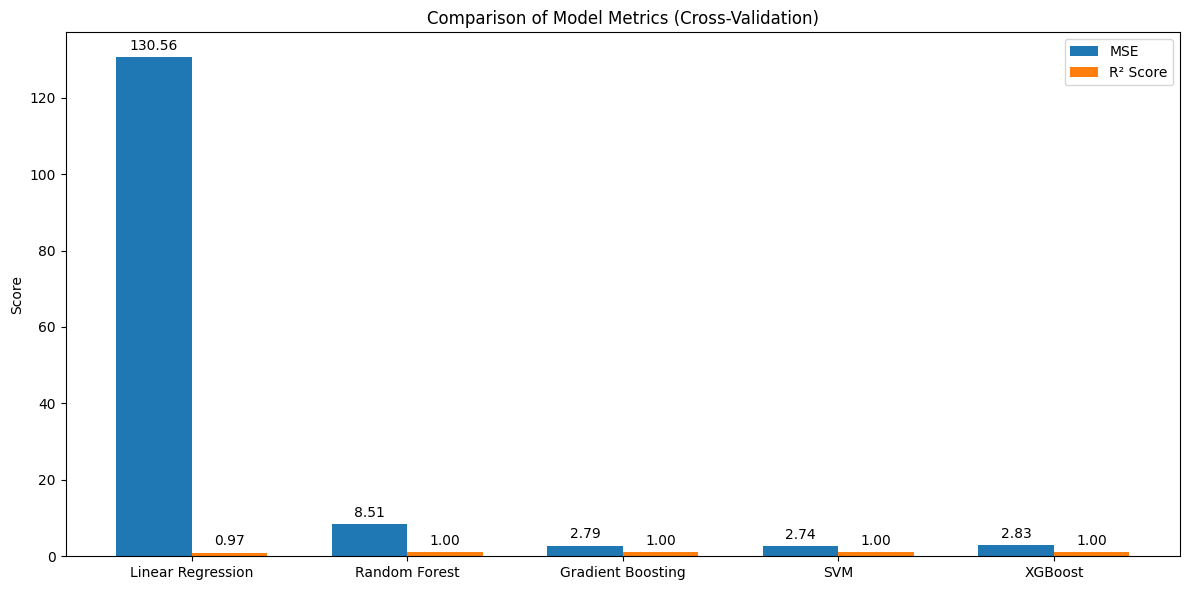

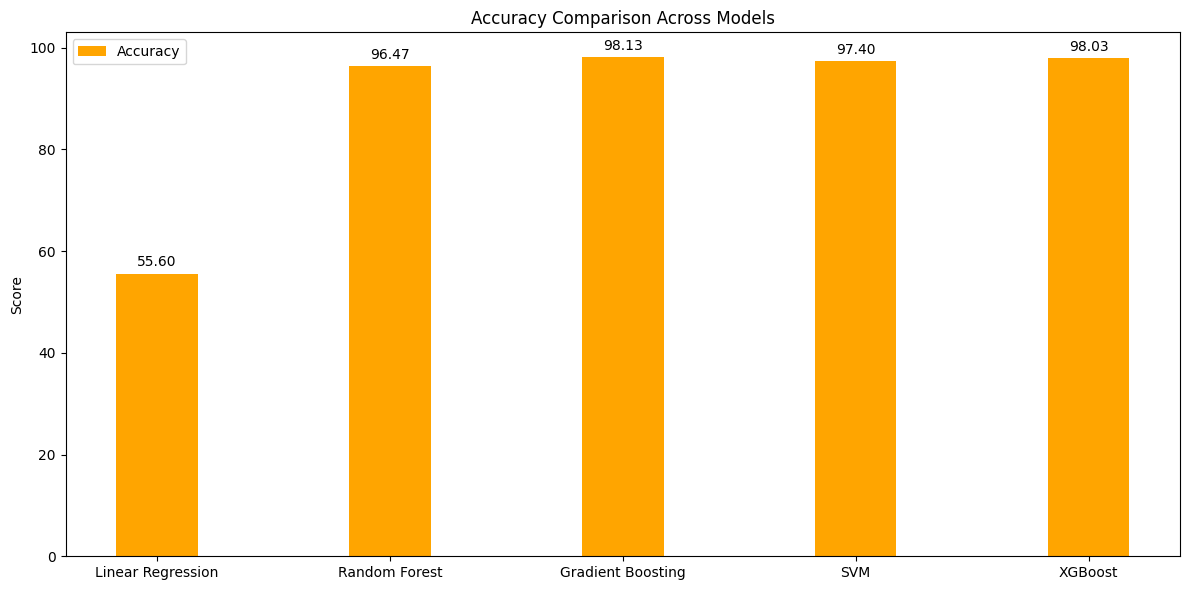

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Provided values
models = ["Linear Regression", "Random Forest", "Gradient Boosting", "SVM", "XGBoost"]
mse_values = mse_values
r2_values = r2_values
accuracy_values = accuracies

# Create bar charts for MSE and R² Score
x = np.arange(len(models))
width = 0.35

# Bar plot for MSE and R²
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width / 2, mse_values, width, label="MSE")
rects2 = ax.bar(x + width / 2, r2_values, width, label="R² Score")

ax.set_ylabel("Score")
ax.set_title("Comparison of Model Metrics (Cross-Validation)")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Annotate bars with values
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}", xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha="center", va="bottom")

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

# Bar plot for Accuracy only
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x, accuracy_values, width, label="Accuracy", color='orange')

ax.set_ylabel("Score")
ax.set_title("Accuracy Comparison Across Models")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

autolabel(rects1)

plt.tight_layout()
plt.show()


This indicates that Gradient Boosting outperforms the other models in both mse/r2 and accuracy grah. Let me know if you need further insights or refinements!

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('regressor', GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42
    ))  # Final model
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Test the pipeline
y_pred = pipeline.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}, R²: {r2:.2f}")


MSE: 2.79, R²: 1.00


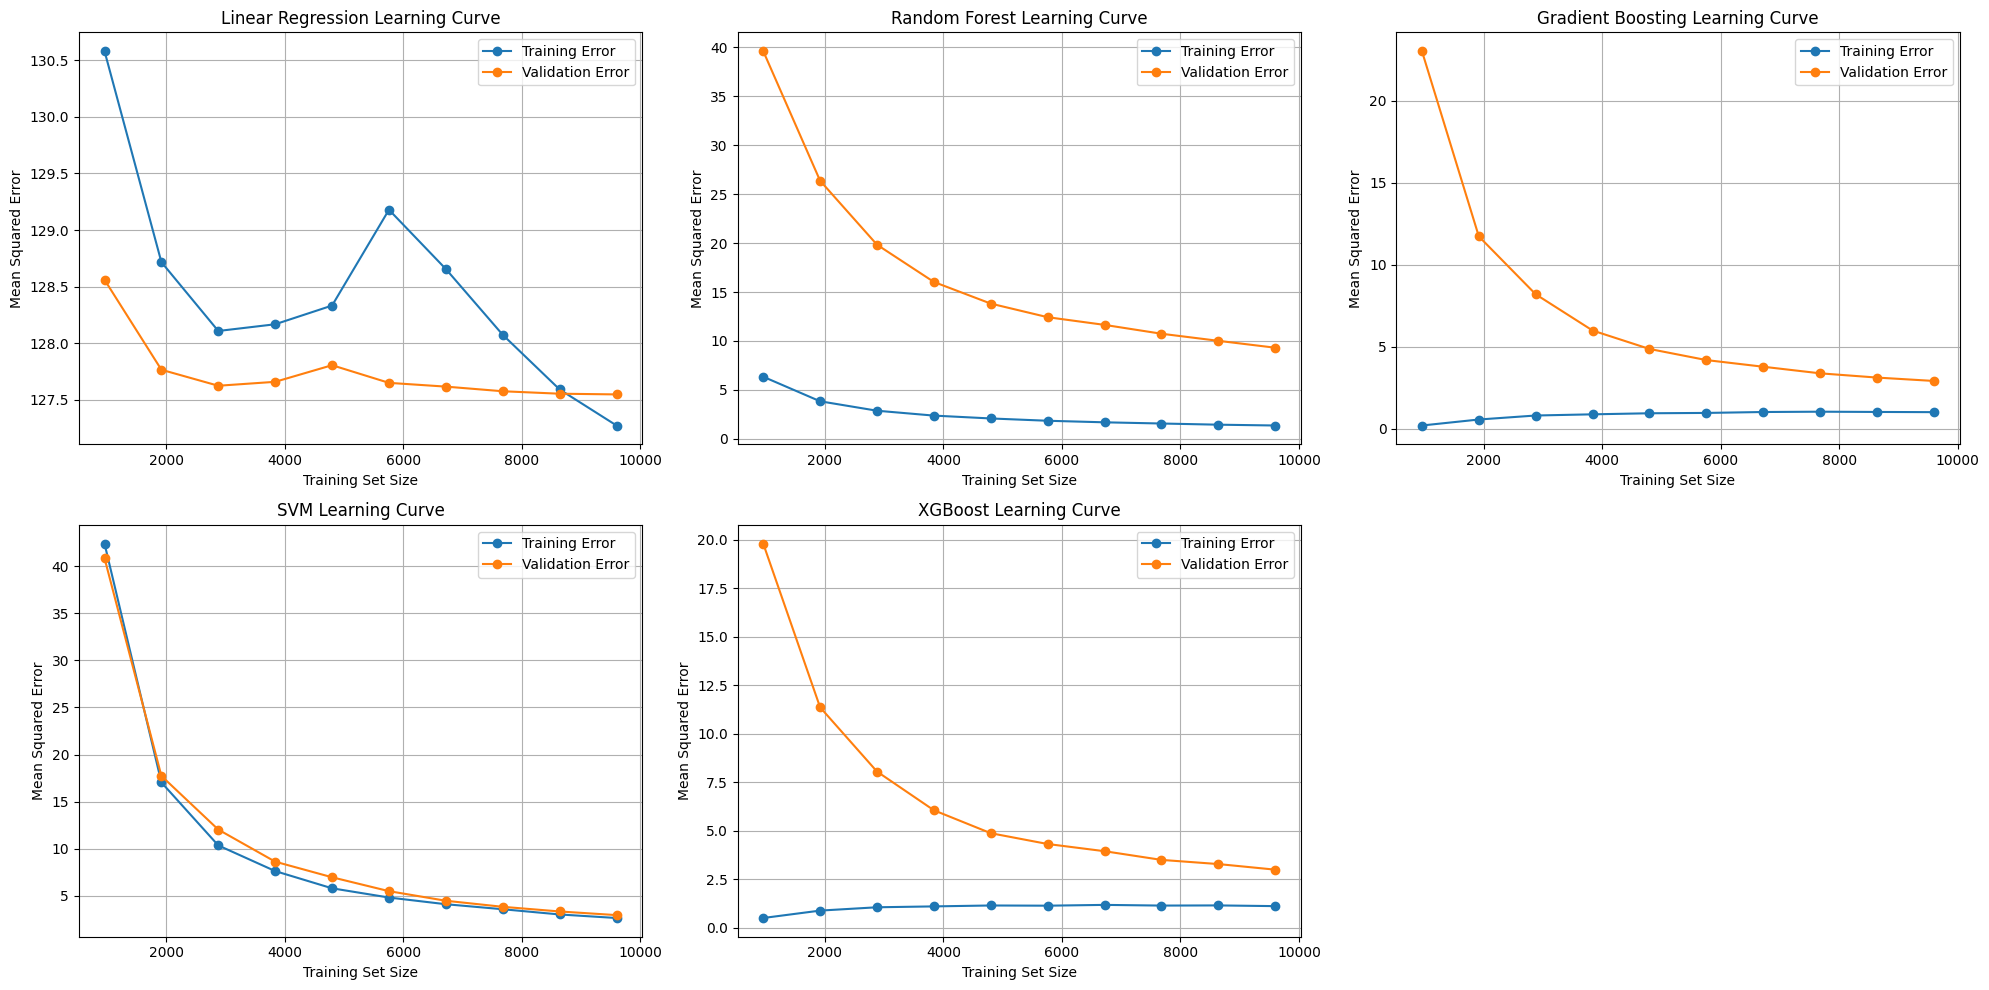

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42),
    "SVM": SVR(kernel="rbf", C=10, epsilon=0.1),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42),
}

# Learning curve function
def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    # Calculate mean of training and validation errors
    train_scores_mean = -np.mean(train_scores, axis=1)  # Convert negative MSE to positive MSE
    test_scores_mean = -np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, label="Training Error", marker='o')
    plt.plot(train_sizes, test_scores_mean, label="Validation Error", marker='o')
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Mean Squared Error")
    plt.legend(loc="best")
    plt.grid()

# Generate learning curves for each model
plt.figure(figsize=(20, 10))
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(2, 3, i)  # Arrange in 2 rows and 3 columns for better layout
    plot_learning_curves(model, X_train_scaled, y_train, title=f"{name} Learning Curve")

plt.tight_layout()
plt.show()


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import set_config

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42
    ))
])

# Enable pipeline diagram visualization
set_config(display='diagram')

# Display the pipeline
pipeline


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=6,
                                           n_estimators=300,
                                           random_state=42))])

In [18]:
from sklearn.model_selection import cross_val_predict
gradient_boosting_regressor = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42
)
y_pred_cv = cross_val_predict(gradient_boosting_regressor, X_train, y_train, cv=5)
gradient_boosting_regressor.fit(X_train, y_train)
y_pred_test = gradient_boosting_regressor.predict(X_test)

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Optimize GradientBoostingRegressor with GridSearchCV
param_grid = {
    "n_estimators": [100, 300, 500],  # Number of trees
    "learning_rate": [0.01, 0.05, 0.1],  # Step size shrinkage
    "max_depth": [3, 5, 7],  # Maximum depth of each tree
    "min_samples_split": [2, 5, 10],  # Minimum samples for splitting a node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf node
}

gradient_boosting_regressor = GradientBoostingRegressor(random_state=42)

# Grid search to find the best parameters
grid_search = GridSearchCV(
    estimator=gradient_boosting_regressor,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,  # Parallel processing
    verbose=1
)

grid_search.fit(X_train, y_train)

# Best estimator and its parameters
best_regressor = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Step 2: Cross-validation predictions on training data
y_pred_cv = cross_val_predict(best_regressor, X_train, y_train, cv=5, n_jobs=-1)

# Evaluate the cross-validation predictions
mse_cv = mean_squared_error(y_train, y_pred_cv)
r2_cv = r2_score(y_train, y_pred_cv)

print(f"Cross-Validation MSE: {mse_cv:.4f}")
print(f"Cross-Validation R²: {r2_cv:.4f}")

# Step 3: Final training and test predictions
best_regressor.fit(X_train, y_train)
y_pred_test = best_regressor.predict(X_test)

# Evaluate on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Test MSE: {mse_test:.4f}")
print(f"Test R²: {r2_test:.4f}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Cross-Validation MSE: 2.0368
Cross-Validation R²: 0.9995
Test MSE: 1.8447
Test R²: 0.9995


In [21]:
import pickle
pickle.dump(gradient_boosting_regressor, open('gradient_boosting_pipeline.pkl', 'wb'))
X_train.to_csv('X_train.csv')
